In [11]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
from pathos.multiprocessing import ProcessPool
import errno
import dill
import sys
sys.path.append('../')

import neat
from hyperneat.new_hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import ObstacleTraverser

import itertools as it
import time
import imageio

import sgr_main as sgr
from matplotlib import pyplot as plt


from substrates import morph_substrate, control_substrate
from generate_robot import generate_robot
from evogym_sim import simulate_env
from body_speciation import new_distance


In [12]:
def get_robot(genome, params, neat_config):
    cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)

    design_substrate = morph_substrate(params)
    design_net = create_phenotype_network(cppn, design_substrate)

    robot = generate_robot(design_net, params)
    if not sgr.eval_genome_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)
    if params["env"] == "dynamic":
        env = ObstacleTraverser(body=robot, connections=connections)
    else:
        env = evogym.envs.gym.make(params["env"], body=robot, connections=connections)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [13]:
ENV = "dynamic" # env_names = ["CaveCrawler-v0", "UpStepper-v0", "ObstacleTraverser-v1"]
STEPS = 600
ROBOT_SIZE = 5
POP = 128

directory = "results/" + ENV
# directory = "results/dynamic"

file = "run_1_pop.pkl"
defaultGen = neat.DefaultGenome
f = lambda self, other, config: new_distance(params, morph_substrate(params), generate_robot, self, other, config)
# defaultGen.distance = f
params = {"robot_size": ROBOT_SIZE, "env": ENV, "steps": STEPS, "pop_size": POP, "robot_substrate": "AA"}
neat_config = neat.config.Config(
    defaultGen,
    neat.reproduction.DefaultReproduction, 
    neat.species.DefaultSpeciesSet, 
    neat.stagnation.DefaultStagnation, 
    "../configs/hyperNEAT_3D_out_robot.cfg"
)

with open(f"../{directory}/{file}", "rb") as file:
    pop = dill.load(file)
champion = pop.best_genome
print(champion.fitness)

0.9927223977175553


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  253 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16119 -0.982427234890987


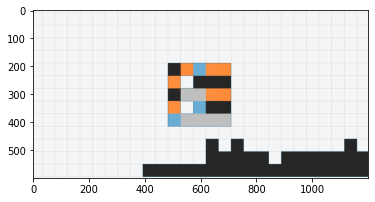

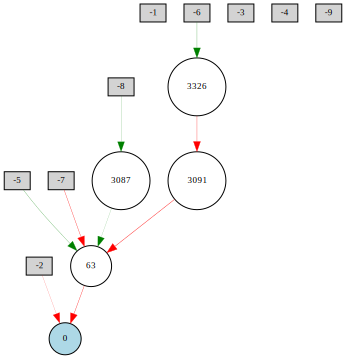

16448 -0.9812472327565862


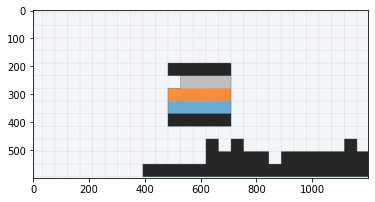

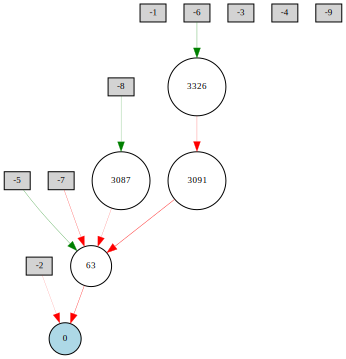

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  259 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16503 -0.7770831120264194


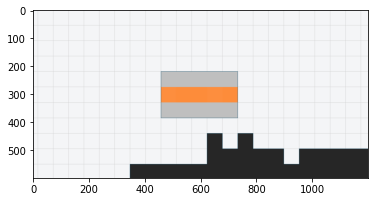

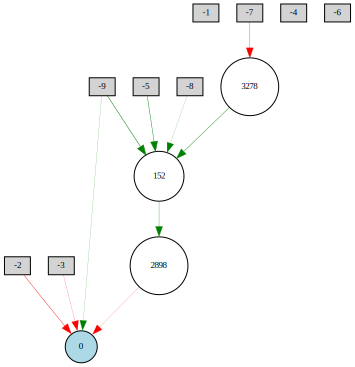

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  251 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16509 -0.7613703720361382


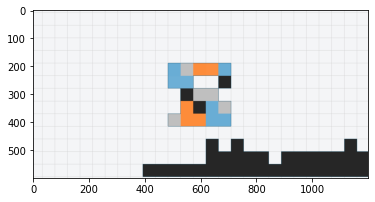

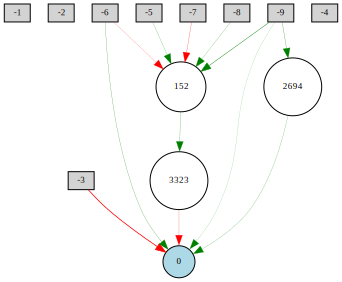

16510 -0.62806216709706


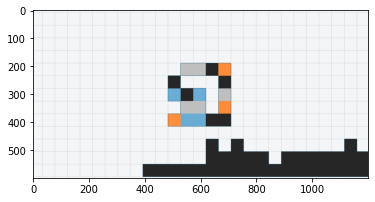

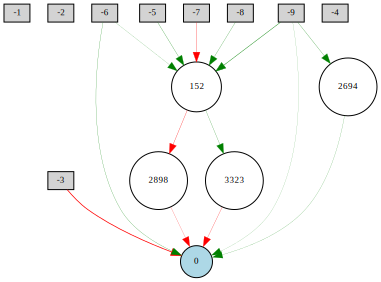

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  260 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16531 -0.6022942158053002


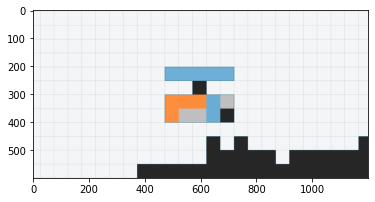

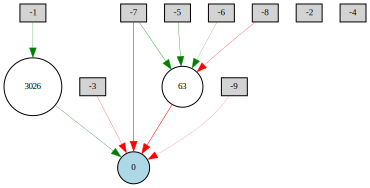

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  248 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16244 -0.7414205502381879


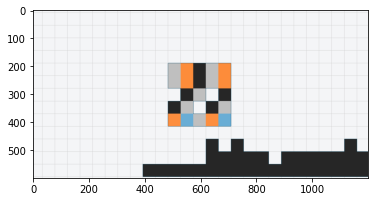

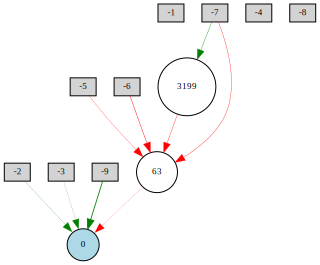

16512 -0.5199889831519664


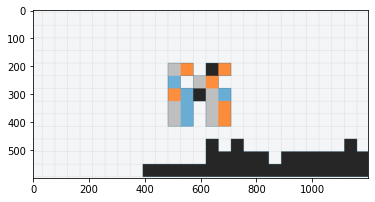

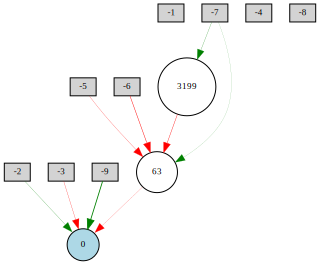

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  257 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16239 -0.8850204128405169


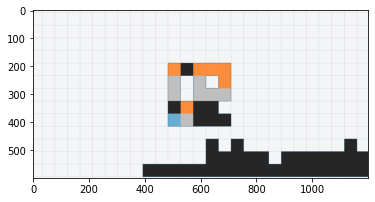

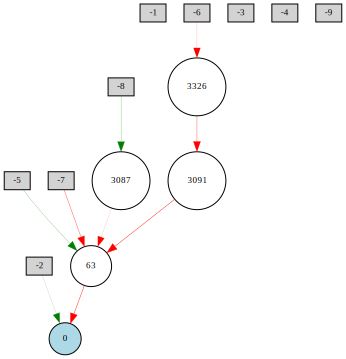

16369 -0.47565397326997083


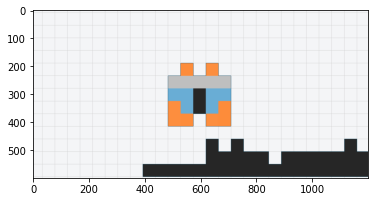

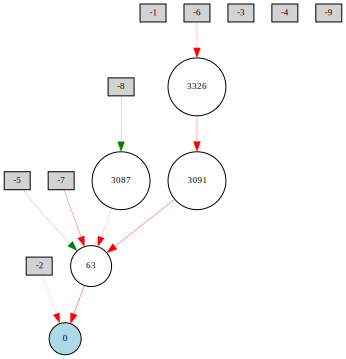

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  258 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16314 -0.42943866293254096


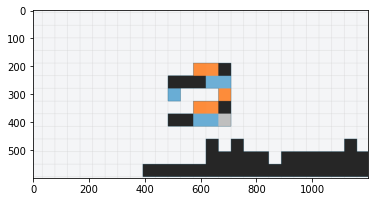

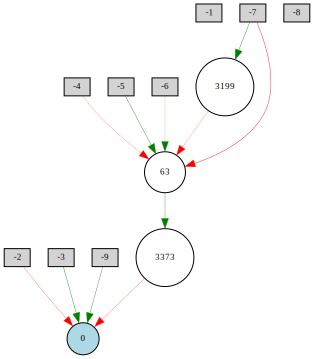

16389 -0.67674322749998


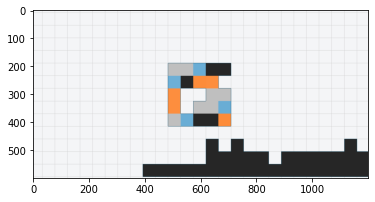

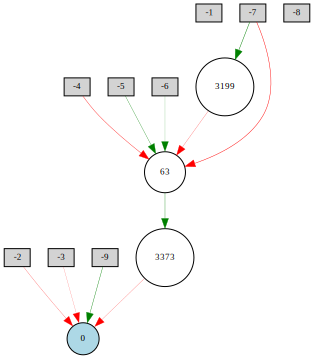

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  254 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16458 -0.3647299295431946


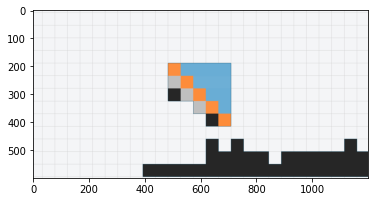

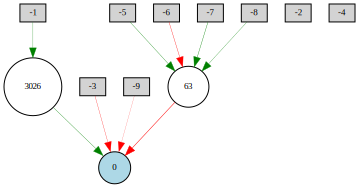

16455 -0.40372876589561274


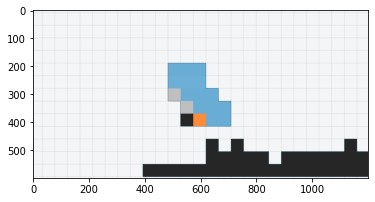

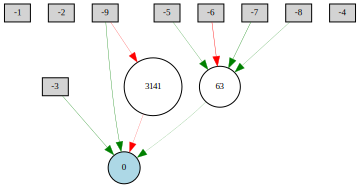

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  256 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16371 -0.0795109487640886


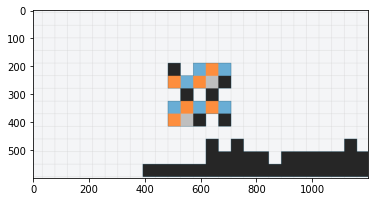

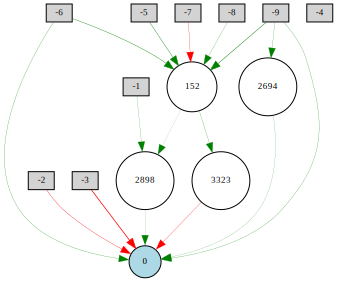

16517 -0.6056634387293378


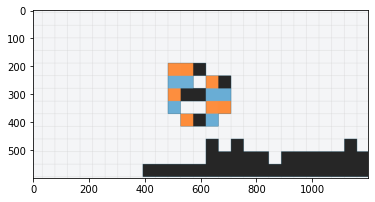

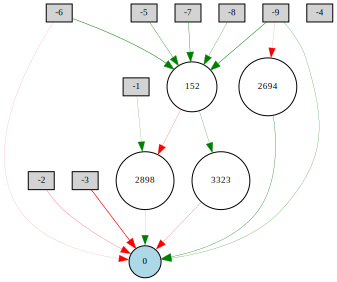

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  252 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
14774 -0.25750902487031235


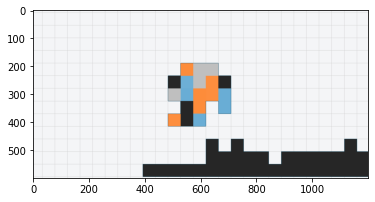

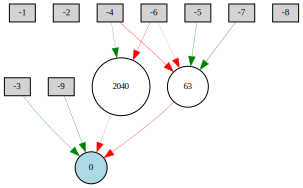

15108 -0.07219091509849118


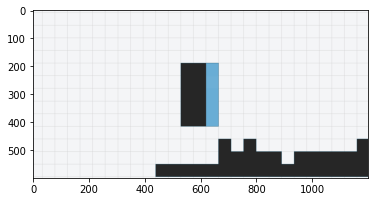

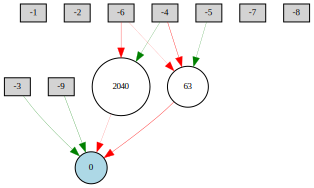

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  234 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16498 -0.40773437034291865


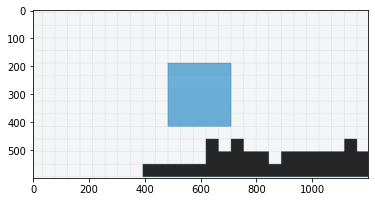

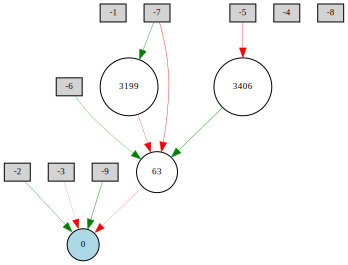

16446 0.021184546710118046


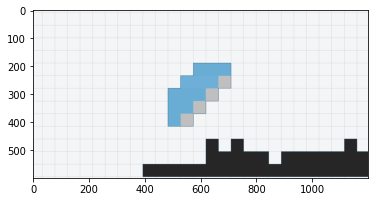

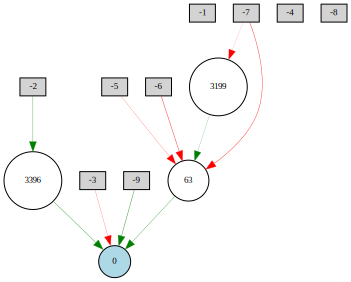

16561 -3.941291737419306e-15


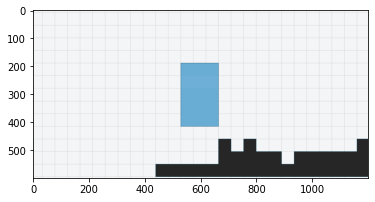

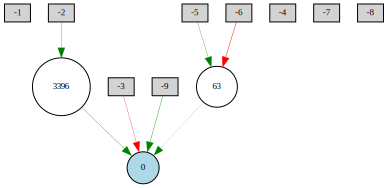

16231 -3.941291737419306e-15


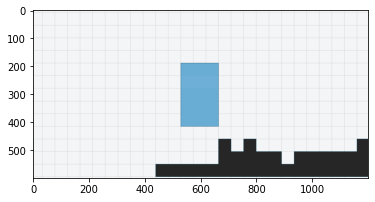

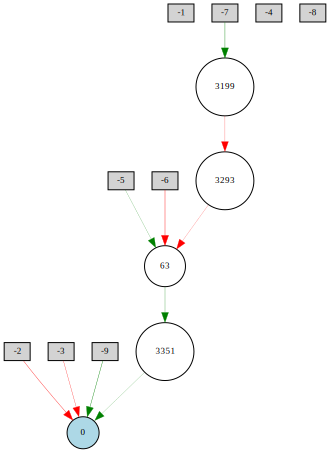

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  243 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  238 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16249 -0.6197655018077991


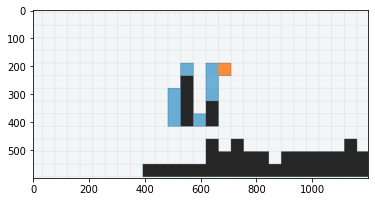

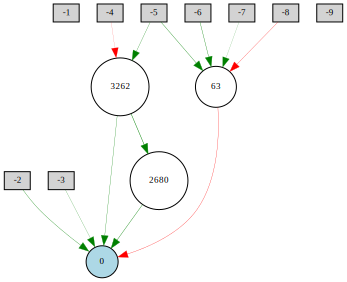

16013 0.09474025195257824


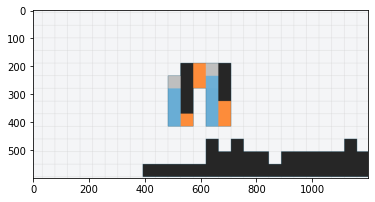

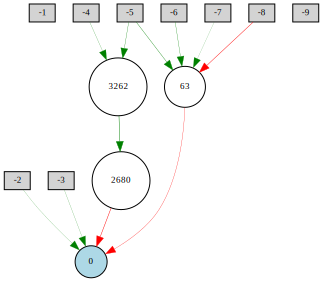

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  255 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16473 0.5412444677049293


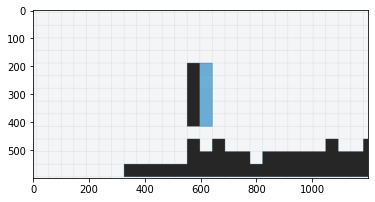

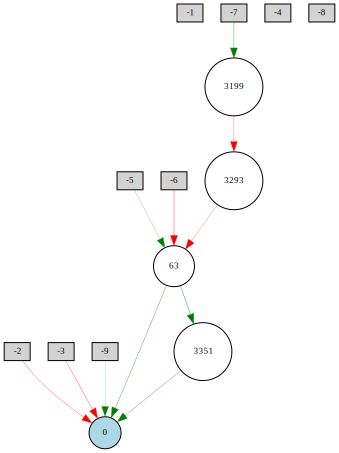

16565 0.42530797187258285


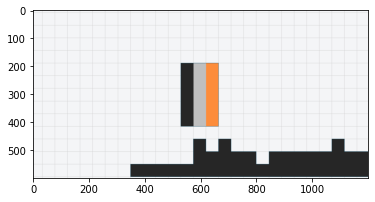

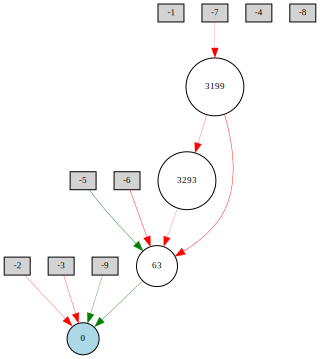

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  261 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
16552 -0.9479412434933105


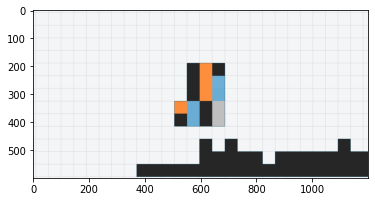

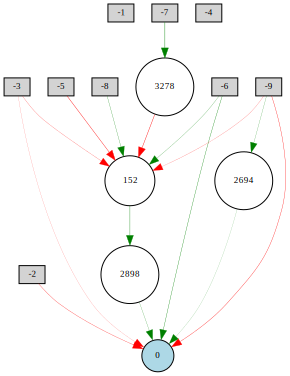

16553 0.9927223977175553


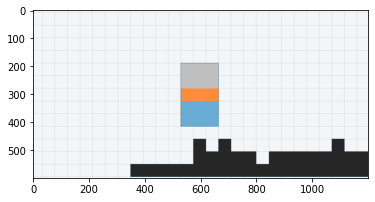

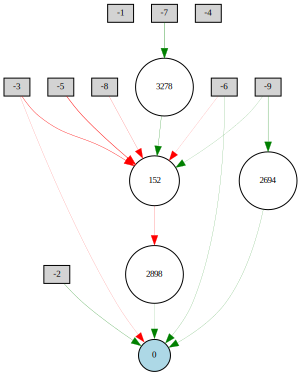

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  262 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [14]:
for k, v in pop.species.species.items():
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie ", k, "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    for g in v.members.values():
        if g.fitness != None and g.fitness > -1:
            r, img = get_robot(g, params, neat_config)
            if img is not None:
                print(g.key, g.fitness)
                plt.imshow(img)
                plt.show()
                net = neat.nn.FeedForwardNetwork.create(g, neat_config)
                display(draw_net(net))

In [15]:
g = champion
# g = pop.population[14774]
params["save_to"] = "flipper_bipedal"
sgr.single_genome_fit(g, params, neat_config, True, False)
# sgr.single_genome_fit(g, params, neat_config, False, True)

(-0.9879108727300844, False)

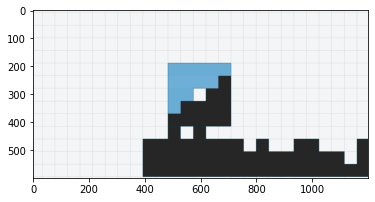

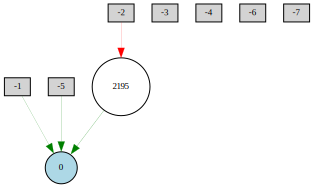

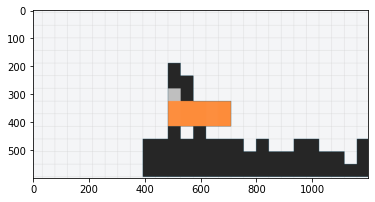

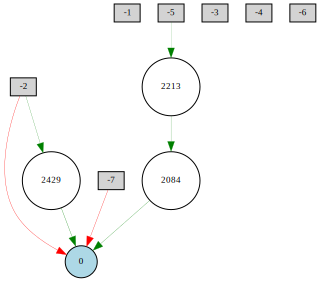

4.716327532073551

2.7363275320735507


In [8]:
base = pop.population[12892]
r2 = pop.population[14520]

_, img = get_robot(base, params, neat_config)
plt.imshow(img)
plt.show()
net = neat.nn.FeedForwardNetwork.create(base, neat_config)
display(draw_net(net))

_, img = get_robot(r2, params, neat_config)
plt.imshow(img)
plt.show()
net = neat.nn.FeedForwardNetwork.create(r2, neat_config)
display(draw_net(net))


neat_config.compatibility_disjoint_coefficient = 1
neat_config.compatibility_weight_coefficient = .6

base.distance = f
print(base.distance(base, r2, neat_config))


print()

base.distance =  neat.DefaultGenome.distance
print(base.distance(base, r2, neat_config))
